In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
from tqdm import tqdm

import torch
torch.hub.set_dir('/kaggle/working')
import torch.nn as nn
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torch.cuda.amp import GradScaler
from sklearn.metrics import accuracy_score

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
print(f"On device : {device}")

On device : cuda


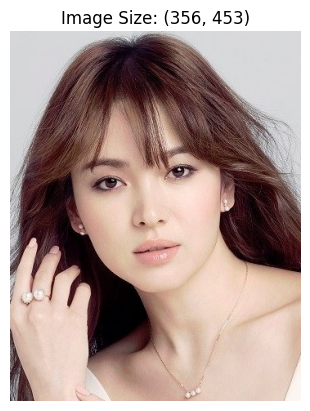

In [4]:
example_image_path = random.choice(os.listdir('../input/face-shape-dataset/FaceShape Dataset/training_set/Oval'))
example_image_path = os.path.join("../input/face-shape-dataset/FaceShape Dataset/training_set/Oval", example_image_path)
example_image = Image.open(example_image_path)

plt.imshow(example_image)
plt.title(f"Image Size: {example_image.size}")
plt.axis('off')
plt.show()

## Now we are going to crop just Face and see the difference in performance

In [5]:
!pip install facenet-pytorch

In [6]:
import cv2
from facenet_pytorch import MTCNN
import shutil

def preprocess_faces(input_dir, output_dir, margin=30):
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize MTCNN on GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    mtcnn = MTCNN(
        select_largest=True,
        post_process=False,
        device=device
    )
    
    # Process each class folder
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        
        # Skip if not a directory
        if not os.path.isdir(class_path):
            continue
            
        # Create output class directory
        output_class_path = os.path.join(output_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)
        
        # Get list of images in class directory
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        # Process each image with progress bar
        for img_file in tqdm(image_files, desc=f"Processing {class_name}"):
            input_img_path = os.path.join(class_path, img_file)
            output_img_path = os.path.join(output_class_path, img_file)
            
            try:
                # Open image
                img = Image.open(input_img_path).convert('RGB')
                
                # Detect face
                boxes, _ = mtcnn.detect(img)
                
                if boxes is not None:
                    # Get coordinates of first face
                    box = boxes[0]
                    x1, y1, x2, y2 = [int(coord) for coord in box]
                    
                    # Add margin
                    width, height = img.size
                    x1 = max(0, x1 - margin)
                    y1 = max(0, y1 - margin)
                    x2 = min(width, x2 + margin)
                    y2 = min(height, y2 + margin)
                    
                    # Crop and save face
                    face_img = img.crop((x1, y1, x2, y2))
                    face_img.save(output_img_path)
                else:
                    # No face detected, save original image
                    img.save(output_img_path)
                    
            except Exception as e:
                print(f"Error processing {input_img_path}: {e}")
                # If error occurs, try using shutil to copy instead
                try:
                    shutil.copy2(input_img_path, output_img_path)
                    print(f"Copied original image using shutil: {input_img_path}")
                except Exception as e2:
                    print(f"Failed to copy using shutil: {e2}")
                    # Last resort: try with OpenCV
                    try:
                        img = cv2.imread(input_img_path)
                        cv2.imwrite(output_img_path, img)
                        print(f"Copied using OpenCV: {input_img_path}")
                    except Exception as e3:
                        print(f"All copy methods failed for {input_img_path}: {e3}")

# Usage with correct paths for Kaggle
input_path = "../input/face-shape-dataset/FaceShape Dataset/training_set"
output_path = "./processed_training_set"
preprocess_faces(input_path, output_path, margin=30)

# Also process testing set
input_test_path = "../input/face-shape-dataset/FaceShape Dataset/testing_set"
output_test_path = "./processed_testing_set"
preprocess_faces(input_test_path, output_test_path, margin=30)

Processing Heart:  29%|██▉       | 232/800 [00:41<01:22,  6.85it/s]

Error processing ../input/face-shape-dataset/FaceShape Dataset/training_set/Heart/heart (633).jpg: image file is truncated (8 bytes not processed)
Copied original image using shutil: ../input/face-shape-dataset/FaceShape Dataset/training_set/Heart/heart (633).jpg


Processing Square:  86%|████████▌ | 689/800 [01:58<00:17,  6.38it/s]

Error processing ../input/face-shape-dataset/FaceShape Dataset/training_set/Square/square (84).jpg: image file is truncated (0 bytes not processed)
Copied original image using shutil: ../input/face-shape-dataset/FaceShape Dataset/training_set/Square/square (84).jpg


Processing Oblong: 100%|██████████| 200/200 [00:41<00:00,  4.83it/s]


In [7]:
# Updated training transforms with MTCNN
train_transforms = T.Compose([
        T.Resize((224, 224)),
        T.RandomHorizontalFlip(),
        T.RandomRotation(degrees=10),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ])

# Updated test transforms with MTCNN
test_transforms = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ])

In [8]:
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count() - 1
TRAIN_PATH = "./processed_training_set"
TEST_PATH = "./processed_testing_set"

def safe_pil_loader(path):
    try:
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    except (OSError, SyntaxError):
        return Image.new('RGB', (224, 224))

train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=train_transforms, loader=safe_pil_loader)
test_dataset = datasets.ImageFolder(root=TEST_PATH, transform=test_transforms, loader=safe_pil_loader)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [9]:
torch.manual_seed(42)

model = torchvision.models.efficientnet_b4(pretrained=True)

num_classes = len(train_dataset.classes)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.BatchNorm1d(model.classifier[1].in_features),
    nn.Linear(model.classifier[1].in_features, 128),  # This is the added layer  
    nn.BatchNorm1d(128),  # Batch normalization for the added layer
    nn.ReLU(inplace=True),  # LeakyReLU activation for the added layer
    nn.Linear(128, num_classes)  # Final layer to predict num_classes
    )

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, betas=(0.9, 0.999), weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

model.to(device)
num_epochs = 25
best_val_loss = 1_000_000

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /kaggle/working/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 159MB/s] 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to 

In [10]:
scaler = GradScaler()

for epoch in range(num_epochs):
    model.train()
    train_losses =  []

    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.autocast(device_type=device, dtype=torch.float16):
          outputs = model(inputs)
          loss = criterion(outputs, labels)

        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()

        train_losses.append(loss.item())

    avg_train_loss = sum(train_losses) / len(train_losses)

    model.eval()
    validation_losses = []
    all_predictions = []
    all_labels = []

    with torch.inference_mode():
      for inputs, labels in test_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        validation_losses.append(loss)

        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

      avg_val_loss = sum(validation_losses) / len(validation_losses)
      scheduler.step(avg_val_loss)

      accuracy = accuracy_score(all_labels, all_predictions)
      print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")

      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        os.makedirs('models', exist_ok=True)
        torch.save(model.state_dict(), 'models/best_model.pth')
print(f'Best Validation Loss: {best_val_loss:.4f}')

Epoch 1/25, Train Loss: 1.3935, Validation Loss: 1.4232, Accuracy: 0.5170
Epoch 2/25, Train Loss: 1.1126, Validation Loss: 1.3692, Accuracy: 0.5040
Epoch 3/25, Train Loss: 0.9526, Validation Loss: 1.0198, Accuracy: 0.6850
Epoch 4/25, Train Loss: 0.8692, Validation Loss: 1.2395, Accuracy: 0.6280
Epoch 5/25, Train Loss: 0.8073, Validation Loss: 1.2187, Accuracy: 0.6100
Epoch 6/25, Train Loss: 0.7556, Validation Loss: 1.1744, Accuracy: 0.6650
Epoch 7/25, Train Loss: 0.7273, Validation Loss: 0.7956, Accuracy: 0.8090
Epoch 8/25, Train Loss: 0.6778, Validation Loss: 0.8757, Accuracy: 0.7650
Epoch 9/25, Train Loss: 0.6592, Validation Loss: 0.7815, Accuracy: 0.8110
Epoch 10/25, Train Loss: 0.6547, Validation Loss: 0.9584, Accuracy: 0.7340
Epoch 11/25, Train Loss: 0.6201, Validation Loss: 0.8371, Accuracy: 0.8010
Epoch 12/25, Train Loss: 0.6149, Validation Loss: 0.8080, Accuracy: 0.8080
Epoch 13/25, Train Loss: 0.5945, Validation Loss: 0.7723, Accuracy: 0.8130
Epoch 14/25, Train Loss: 0.6049, V

Classification Report:
              precision    recall  f1-score   support

       Heart       0.93      0.88      0.90       200
      Oblong       0.94      0.92      0.93       200
        Oval       0.84      0.82      0.83       200
       Round       0.81      0.90      0.85       200
      Square       0.93      0.93      0.93       200

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



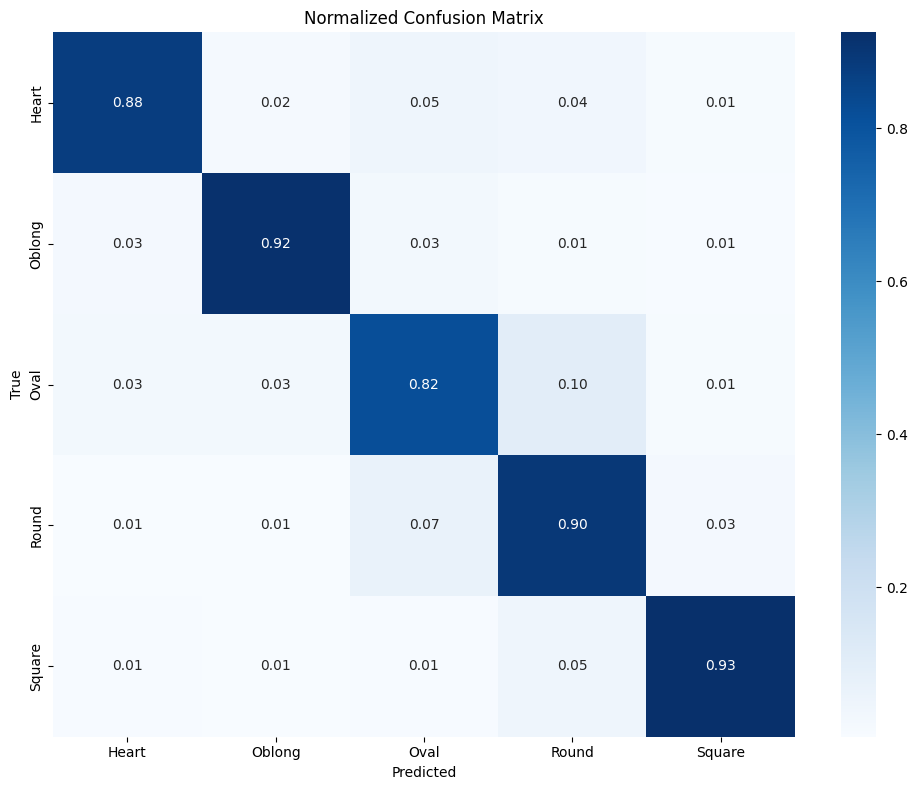

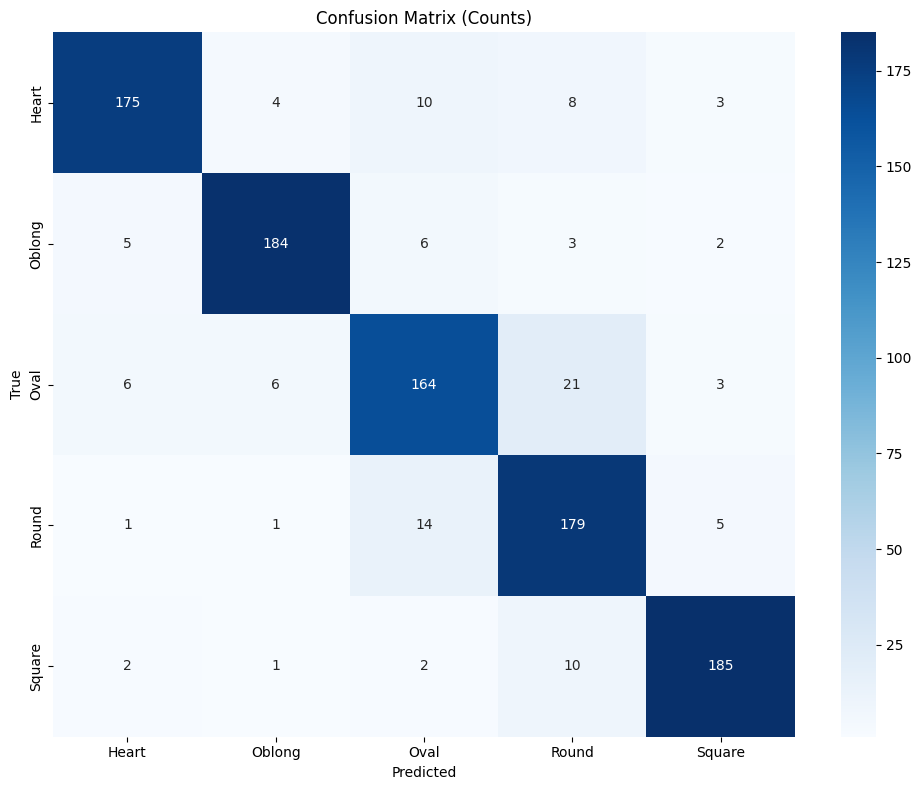

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, test_loader, class_names, device):
    # Initialize lists to store predictions and ground truth
    all_preds = []
    all_labels = []
    
    # Set model to evaluation mode
    model.eval()
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Get predictions
            _, preds = torch.max(outputs, 1)
            
            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Normalize the confusion matrix (optional)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    # Plot the raw counts (optional)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Counts)')
    plt.tight_layout()
    plt.show()
    
    return cm, cm_normalized

# Example usage
class_names = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']  # Adjust to match your classes
cm, cm_norm = plot_confusion_matrix(model, test_loader, class_names, device)

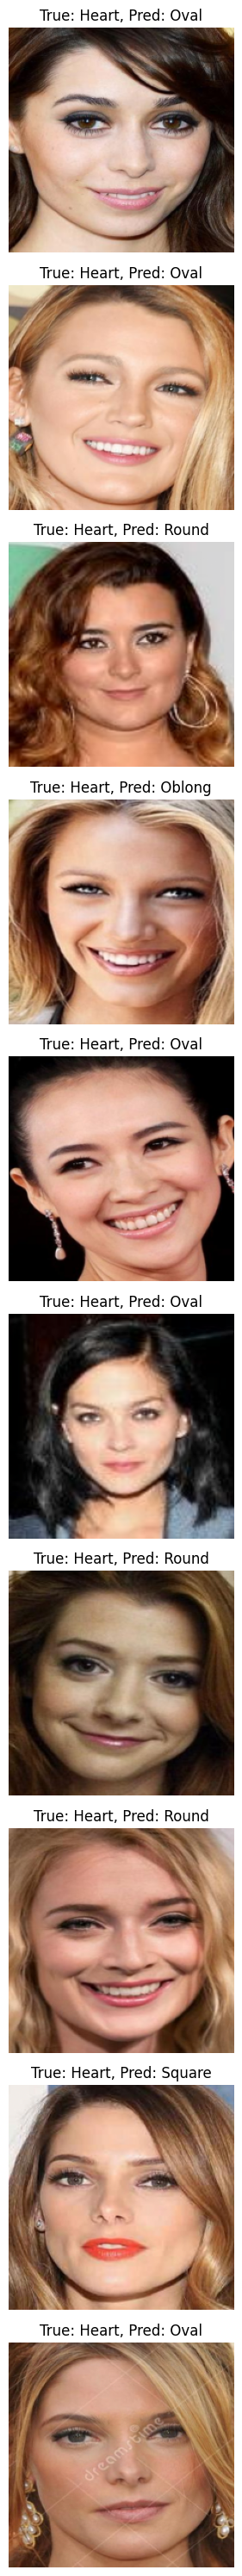

Total misclassified images: 113


In [47]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

def find_misclassified_images(model, test_loader, class_names, device, max_display=10):
    # Set model to evaluation mode
    model.eval()
    
    # Lists to store misclassified data
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    misclassified_indices = []
    
    # Inverse transform to convert tensors back to images
    inv_transform = transforms.Compose([
        transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        ),
    ])
    
    # Get predictions
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Find misclassified images in this batch
            incorrect_mask = preds != labels
            if incorrect_mask.any():
                for i, is_wrong in enumerate(incorrect_mask):
                    if is_wrong:
                        img = inv_transform(inputs[i].cpu()).permute(1, 2, 0).numpy()
                        img = np.clip(img, 0, 1)  # Clip values to valid range
                        
                        misclassified_images.append(img)
                        misclassified_labels.append(labels[i].item())
                        misclassified_preds.append(preds[i].item())
                        misclassified_indices.append(batch_idx * test_loader.batch_size + i)
    
    # Display misclassified images
    n_display = min(len(misclassified_images), max_display)
    
    if n_display > 0:
        fig, axes = plt.subplots(nrows=n_display, ncols=1, figsize=(8, n_display*3))
        
        if n_display == 1:
            axes = [axes]
            
        for i in range(n_display):
            axes[i].imshow(misclassified_images[i])
            axes[i].set_title(f"True: {class_names[misclassified_labels[i]]}, "
                             f"Pred: {class_names[misclassified_preds[i]]}")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    print(f"Total misclassified images: {len(misclassified_images)}")
    
    # Create a dictionary with all the information
    misclassified_info = {
        'images': misclassified_images,
        'true_labels': [class_names[label] for label in misclassified_labels],
        'predicted_labels': [class_names[pred] for pred in misclassified_preds],
        'indices': misclassified_indices
    }
    
    return misclassified_info

# Example usage
class_names = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']  # Adjust to match your classes
misclassified = find_misclassified_images(model, test_loader, class_names, device)

In [52]:
def get_misclassified_file_paths(test_dataset, misclassified_indices):
    """
    Get the file paths of misclassified images.
    
    Args:
        test_dataset: Your test dataset (must have a 'samples' attribute with paths)
        misclassified_indices: Indices of misclassified images from find_misclassified_images
    
    Returns:
        List of file paths for misclassified images
    """
    if hasattr(test_dataset, 'samples'):
        file_paths = [test_dataset.samples[idx][0] for idx in misclassified_indices]
        return file_paths
    elif hasattr(test_dataset, 'imgs'):
        file_paths = [test_dataset.imgs[idx][0] for idx in misclassified_indices]
        return file_paths
    else:
        print("Dataset doesn't have a 'samples' or 'imgs' attribute")
        return None

# Get file paths
misclassified_paths = get_misclassified_file_paths(test_dataset, misclassified['indices'])

# Print the first few file paths
if misclassified_paths:
    for i, path in enumerate(misclassified_paths):
        if misclassified['true_labels'][i] == "Oval":
            print(f"Misclassified {i+1}: {path}")
            print(f"  True: {misclassified['true_labels'][i]}, Predicted: {misclassified['predicted_labels'][i]}")

Misclassified 42: ./processed_testing_set/Oval/oval (140).jpg
  True: Oval, Predicted: Round
Misclassified 43: ./processed_testing_set/Oval/oval (144).jpg
  True: Oval, Predicted: Round
Misclassified 44: ./processed_testing_set/Oval/oval (195).jpg
  True: Oval, Predicted: Heart
Misclassified 45: ./processed_testing_set/Oval/oval (237).jpg
  True: Oval, Predicted: Round
Misclassified 46: ./processed_testing_set/Oval/oval (246).jpg
  True: Oval, Predicted: Oblong
Misclassified 47: ./processed_testing_set/Oval/oval (249).jpg
  True: Oval, Predicted: Round
Misclassified 48: ./processed_testing_set/Oval/oval (258).jpg
  True: Oval, Predicted: Oblong
Misclassified 49: ./processed_testing_set/Oval/oval (388).jpg
  True: Oval, Predicted: Heart
Misclassified 50: ./processed_testing_set/Oval/oval (397).jpg
  True: Oval, Predicted: Heart
Misclassified 51: ./processed_testing_set/Oval/oval (398).jpg
  True: Oval, Predicted: Round
Misclassified 52: ./processed_testing_set/Oval/oval (400).jpg
  True

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torchvision.transforms as T

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def __call__(self, x, class_idx=None):
        # Forward pass
        self.model.eval()
        logits = self.model(x)
        
        # If class_idx is None, use the predicted class
        if class_idx is None:
            class_idx = torch.argmax(logits, dim=1)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Target for backprop
        one_hot = torch.zeros_like(logits)
        one_hot[0, class_idx] = 1
        
        # Backward pass
        logits.backward(gradient=one_hot, retain_graph=True)
        
        # Get weights
        gradients = self.gradients.mean([0, 2, 3])  # Global average pooling
        
        # Get activations
        activations = self.activations[0]
        
        # Weight activations by gradients
        weighted_activations = activations * gradients.view(activations.size(0), 1, 1)
        
        # Sum along the channel dimension
        cam = torch.sum(weighted_activations, dim=0).cpu().numpy()
        
        # ReLU
        cam = np.maximum(cam, 0)
        
        # Normalize
        if np.max(cam) > 0:
            cam = cam / np.max(cam)
        
        return cam

# Usage example
def visualize_gradcam(model, img_path, target_layer, class_names, transform=None):
    # Load and preprocess the image
    img = Image.open(img_path).convert('RGB')
    
    if transform is None:
        transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    input_tensor = transform(img).unsqueeze(0).to(device)
    
    # Create GradCAM object
    grad_cam = GradCAM(model, target_layer)
    
    # Get model prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
    
    # Get heatmap
    heatmap = grad_cam(input_tensor, predicted_class)
    
    # Resize heatmap to match original image
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
    
    # Convert to RGB heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Superimpose heatmap on original image
    np_img = np.array(img)
    superimposed_img = heatmap * 0.4 + np_img * 0.6
    superimposed_img = np.uint8(superimposed_img)
    
    # Display results
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    ax[1].imshow(heatmap)
    ax[1].set_title('Grad-CAM Heatmap')
    ax[1].axis('off')
    
    ax[2].imshow(superimposed_img)
    ax[2].set_title(f'Prediction: {class_names[predicted_class]}')
    ax[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return heatmap, superimposed_img, class_names[predicted_class]

./processed_testing_set//Oval/oval (436).jpg


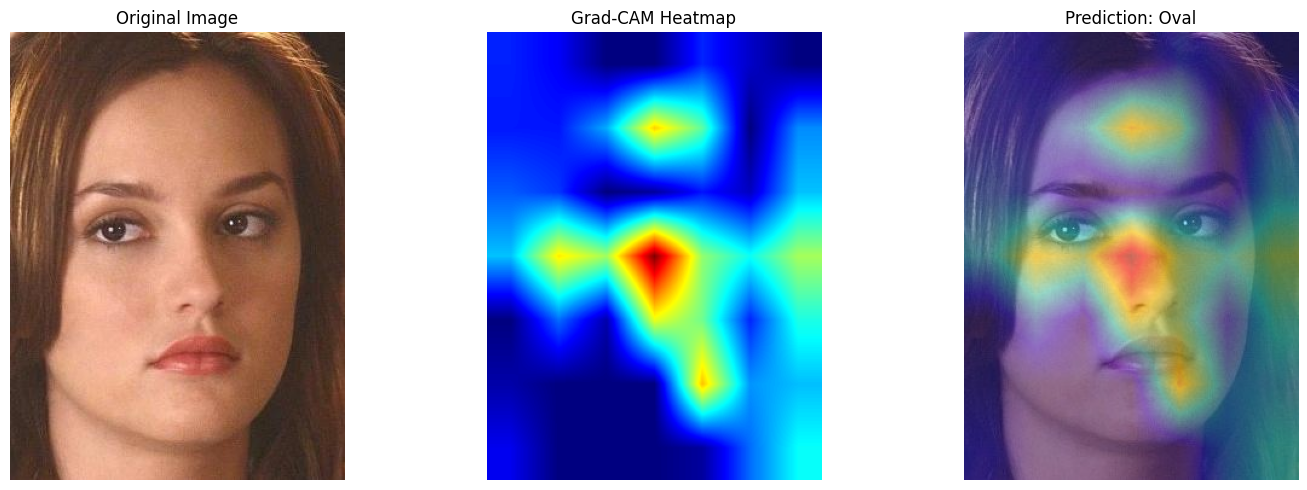

In [59]:
# Find the target layer (usually the last convolutional layer)
# For EfficientNet-B4:
target_layer = model.features[-1][0]  # Last conv block

# For ResNet-50:
# target_layer = model.layer4[-1].conv3  # Last conv layer

# Define your class names
class_names = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']  # Adjust as needed

# Run Grad-CAM visualization
img_path = './processed_testing_set//Oval/oval (436).jpg'
print(img_path)
heatmap, overlay, prediction = visualize_gradcam(model, img_path, target_layer, class_names)